In [1]:
# ! ssh -fNL 27017:localhost:27017 bonnen@rxdhawkins.me

In [28]:
import datetime, os, json, boto, pymongo, numpy, h5py
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.patches as mpatches
import warnings; warnings.simplefilter('ignore')
import pandas
a = np.array
pretty = ['lightgrey', '#00aba9', '#ff0097', '#a200ff', '#1ba1e2', '#f09609'] 
from scipy.stats import zscore as z

In [29]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [30]:
# load credentials to access the database, connect, identify collection
data = json.load(open('./.credentials/auth.json'))
mongo_tunnel = 'mongodb://' + data['user'] + ':' + data['password'] + '@127.0.0.1'
connection = pymongo.MongoClient(mongo_tunnel)
data_base = connection['sleep_affect_memory']
collection = data_base['replication']

In [31]:
one_subject = collection.find({'personal_tag':'tyler_pilot_0'})

In [58]:
exclude = ['NONE', 'A33F2FVAMGJDGG']
all_workers = [i for i in collection.distinct('worker_id') if i not in exclude]

In [116]:
complete = [] 
for i_worker in all_workers: 
    tmp_data = collection.find({'worker_id':i_worker})
    if 'worker_feedback' in tmp_data[tmp_data.count()-1]['trial_data']: 
        complete.append(i_worker)
   

In [121]:
ignore = ['trial_index', 
          'time_elapsed', 
          'stimulus', 
          'correct_response', 
          'internal_node_id', 
          'key_press', 
          'trial_type']

In [213]:
subject_trial_data = pandas.DataFrame()

# convert to pandas dataframe 

for i_worker in complete: 
    i_data = collection.find({'worker_id':i_worker})
    
    for one_trial in i_data: 

        q = {i:one_trial['trial_data'][i] for i in list(one_trial['trial_data'].keys()) if i not in ignore}
        q['subject'] = one_trial['worker_id']
        subject_trial_data = subject_trial_data.append(q, ignore_index=True)


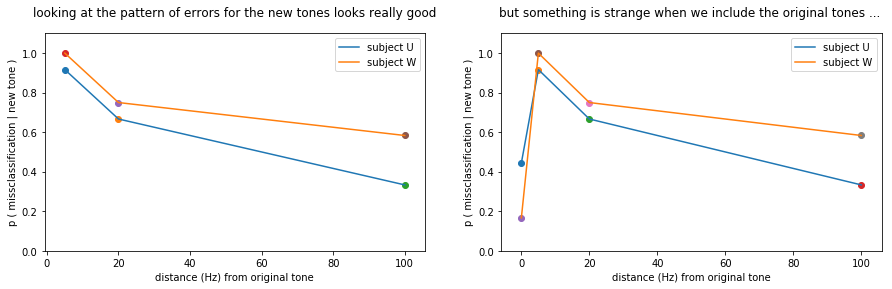

In [226]:
figure(figsize=[15, 4])
subplot(121)
for i_subject in complete: 
    one_subject = subject_trial_data[subject_trial_data.subject == i_subject]
    one_generalization = one_subject[(one_subject.stage == 'generalization') * (one_subject.valence != 'control')]
    one_generalization.distance = np.abs(one_generalization.distance) 
    colors = ['red', 'orange', 'green', 'blue']
    tmp_pattern = [] 
    for i_distance in [i for i in np.sort(one_generalization.distance.unique())  if i != 0]: 
        i_misclassification = 1-one_generalization[one_generalization.distance == i_distance].correct.mean()
        scatter(i_distance, i_misclassification) 
        tmp_pattern.append([i_distance, i_misclassification])
    plot([j[0] for j in tmp_pattern], [j[1] for j in tmp_pattern], label='subject %s'%i_subject[3])

ylim(0,1.1)
legend() 
ylabel('p ( missclassification | new tone )')
xlabel('distance (Hz) from original tone'); 
title("looking at the pattern of errors for the new tones looks really good", y=1.05)

subplot(122)
for i_subject in complete: 
    one_subject = subject_trial_data[subject_trial_data.subject == i_subject]
    one_generalization = one_subject[(one_subject.stage == 'generalization') * (one_subject.valence != 'control')]
    one_generalization.distance = np.abs(one_generalization.distance) 
    colors = ['red', 'orange', 'green', 'blue']
    tmp_pattern = [] 
    for i_distance in np.sort(one_generalization.distance.unique()): 
        i_misclassification = 1-one_generalization[one_generalization.distance == i_distance].correct.mean()
        scatter(i_distance, i_misclassification) 
        tmp_pattern.append([i_distance, i_misclassification])
    plot([j[0] for j in tmp_pattern], [j[1] for j in tmp_pattern], label='subject %s'%i_subject[3])

ylim(0,1.1)
legend() 
ylabel('p ( missclassification | new tone )')
xlabel('distance (Hz) from original tone'); 
title("but something is strange when we include the original tones ... ", y=1.05); 


Text(0.5,0,'distance (Hz) from original tone')

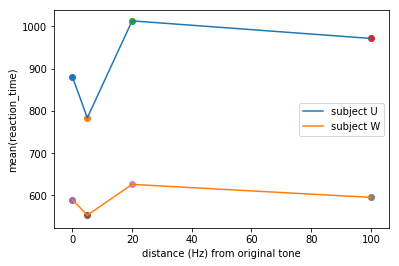

In [244]:
figure()
for i_subject in complete: 
    one_subject = subject_trial_data[subject_trial_data.subject == i_subject]
    one_generalization = one_subject[(one_subject.stage == 'generalization') * (one_subject.valence != 'control')]
    one_generalization.distance = np.abs(one_generalization.distance) 
    colors = ['red', 'orange', 'green', 'blue']
    tmp_pattern = [] 
    for i_distance in np.sort(one_generalization.distance.unique()): 
        i_misclassification = one_generalization[one_generalization.distance == i_distance].rt.mean()
        scatter(i_distance, i_misclassification) 
        tmp_pattern.append([i_distance, i_misclassification])
    plot([j[0] for j in tmp_pattern], [j[1] for j in tmp_pattern], label='subject %s'%i_subject[3])
legend() 
ylabel('mean(reaction_time)')
xlabel('distance (Hz) from original tone')



subplot(122)

for i_subject in complete: 
    one_subject = subject_trial_data[subject_trial_data.subject == i_subject]
    one_generalization = one_subject[(one_subject.stage == 'generalization') * (one_subject.valence != 'control')]
    one_generalization.distance = np.abs(one_generalization.distance) 
    colors = ['red', 'orange', 'green', 'blue']
    tmp_pattern = [] 
    for i_distance in np.sort(one_generalization.distance.unique()): 
        i_misclassification = one_generalization[one_generalization.distance == i_distance].rt.mean()
        tmp_pattern.append([i_distance, i_misclassification])
    plot([j[0] for j in tmp_pattern], [j[1] for j in tmp_pattern], label='subject %s'%i_subject[3])
    scatter(one_generalization.distance.values, one_generalization.rt.values)
legend() 



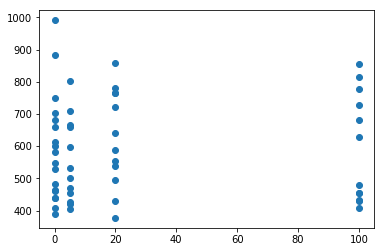

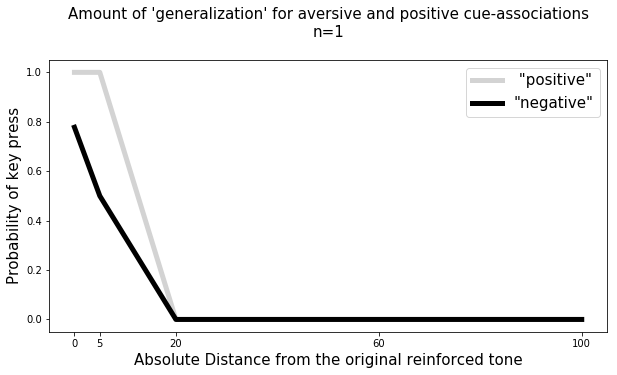

In [26]:
# pilot 0 script

one_subject = collection.find({'personal_tag':'tyler_pilot_0'})

subject_trial_data = pandas.DataFrame()

for one_trial in one_subject: 
    
    q = {i_key:one_trial['trial_data'][i_key] for i_key in list(one_trial['trial_data'].keys())}
    
    subject_trial_data = subject_trial_data.append(q, ignore_index=True)


subject_trial_data['frequency'] = [ int(i_stim[-3:]) for i_stim in subject_trial_data['stimulus'].values]

instrumental = (subject_trial_data['condition'].values == 'instrumental')
response_not_space = (subject_trial_data['correct_response'].values !='space')
responses = subject_trial_data.correct[ instrumental * response_not_space].values

generalization_stage = subject_trial_data[subject_trial_data.stage == 'generalization']
frequencies = generalization_stage.frequency.unique() 
corrects = generalization_stage.correct.values

def convert_to_abs_difference(type_responses): 
        
    if type_responses=='p': 
        type_tones = a([300, 305, 295, 280, 320, 240, 360, 200, 400])
        type_responses = generalization_stage.key_press.values == 80
    elif type_responses=='q': 
        type_tones = a([700, 705, 695, 720, 680, 760, 640, 800, 600])
        type_responses = generalization_stage.key_press.values == 81
    elif type_responses == 'space': 
        type_tones = [500, 480, 520, 600, 400]
        type_responses = generalization_stage.key_press.values == 32
    
    
    presses = [type_responses[generalization_stage.frequency == hz ].mean() for hz in type_tones]
    press_by_distance = [np.mean(presses[i:i+2]) for i in  np.arange(1, len(presses)-1,2)]
    
    press_by_distance = [presses[0]*1] + press_by_distance
    return press_by_distance


p_presses_by_distance = convert_to_abs_difference('p')
q_presses_by_distance = convert_to_abs_difference('q')
s_presses_by_distance = convert_to_abs_difference('space')


plt.figure(figsize=[10,5])
plt.plot([0,5, 20, 60, 100], p_presses_by_distance, label=' "positive"', color='lightgrey', alpha=1, 
         linewidth=5)


plt.plot([0,5, 20, 60, 100], q_presses_by_distance, label='"negative"', color='black', alpha=1, linewidth=5)

#plt.plot([0, 20, 100], q_presses_by_distance, label='"negative"', color='black', alpha=1, linewidth=5)


plt.xlabel("Absolute Distance from the original reinforced tone", fontsize=15)
plt.ylabel('Probability of key press', fontsize=15)
plt.xticks([0,5,20,60,100])
plt.legend(fontsize=15) 
plt.title("Amount of 'generalization' for aversive and positive cue-associations\nn=1\n", fontsize=15);
